# Overview
Do you scan online retailers in search of the best deals? You're joined by the many savvy shoppers who don't like paying extra for the same product depending on where they shop. Retail companies use a variety of methods to assure customers that their products are the cheapest. Among them is product matching, which allows a company to offer products at rates that are competitive to the same product sold by another retailer. To perform these matches automatically requires a thorough machine learning approach, which is where your data science skills could help.

Two different images of similar wares may represent the same product or two completely different items. Retailers want to avoid misrepresentations and other issues that could come from conflating two dissimilar products. Currently, a combination of deep learning and traditional machine learning analyzes image and text information to compare similarity. But major differences in images, titles, and product descriptions prevent these methods from being entirely effective.

Shopee is the leading e-commerce platform in Southeast Asia and Taiwan. Customers appreciate its easy, secure, and fast online shopping experience tailored to their region. The company also provides strong payment and logistical support along with a 'Lowest Price Guaranteed' feature on thousands of Shopee's listed products.

In this competition, you’ll apply your machine learning skills to build a model that predicts which items are the same products.

The applications go far beyond Shopee or other retailers. Your contributions to product matching could support more accurate product categorization and uncover marketplace spam. Customers will benefit from more accurate listings of the same or similar products as they shop. Perhaps most importantly, this will aid you and your fellow shoppers in your hunt for the very best deals.


# Purpose
Finding near-duplicates in large datasets is an important problem for many online businesses. In Shopee's case, everyday users can upload their own images and write their own product descriptions, adding an extra layer of challenge. **Your task is to identify which products have been posted repeatedly.** The differences between related products may be subtle while photos of identical products may be wildly different!


# Data Description
`[train/test].csv` - the training set metadata. Each row contains the data for a single posting. Multiple postings might have the exact same image ID, but with different titles or vice versa.

`posting_id` - the ID code for the posting.

`image` - the image id/md5sum.

`image_phash` - a perceptual hash of the image.

`title` - the product description for the posting.

`label_group` - ID code for all postings that map to the same product. Not provided for the test set.

`[train/test]images` - the images associated with the postings.

# Setup GPU parameters

In [ ]:
# RESTRICT TENSORFLOW TO 5GB OF GPU RAM
# SO THAT WE HAVE 14GB RAM FOR RAPIDS

import tensorflow as tf

LIMIT = 5.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        #print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print('We will restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('then RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

We will restrict TensorFlow to max 5GB GPU RAM
then RAPIDS can use 11GB GPU RAM


# Import dataset from Kaggle

In [ ]:
# install Kaggle on goggle colab
# !pip install -q kaggle

In [1]:
from google.colab import files

files.upload() # import user API from kaggle (.json file)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emilsagre","key":"59587c0ef9f7b2adf1f0e8a20a617218"}'}

In [ ]:
# create kaggle folder
! mkdir ~/.kaggle

In [3]:
# copy the kaggle.json folder created
! cp kaggle.json ~/.kaggle/

In [4]:
# permission for the json to act
! chmod 600 ~/.kaggle.json

chmod: cannot access '/root/.kaggle.json': No such file or directory


In [ ]:
# list all dataset in kaggle

## ! kaggle datasets list

In [5]:
!kaggle competitions download -c shopee-product-matching

 99% 1.67G/1.68G [00:27<00:00, 76.6MB/s]
100% 1.68G/1.68G [00:27<00:00, 66.7MB/s]


In [6]:
# unzip files
!unzip shopee-product-matching.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/d8fce6d90ff1c758810b2132d8d9a84e.jpg  
  inflating: train_images/d90143423d8db45b382f2dee3d01fcb1.jpg  
  inflating: train_images/d903b2ab37c0418bfeb7e6e5304b64a4.jpg  
  inflating: train_images/d905748b1f61121cdcc7ae397b97052b.jpg  
  inflating: train_images/d906df4fdf70397d4f04ef0fe6ea1fe2.jpg  
  inflating: train_images/d9074f43948053971953322ed8ddc2cf.jpg  
  inflating: train_images/d9076a1375bb05c33edd5a1f1684e1f0.jpg  
  inflating: train_images/d9093fbb00a2013aad7cbcd993d779ab.jpg  
  inflating: train_images/d90ac3ff5b7d6371c50b3ef737002084.jpg  
  inflating: train_images/d90c105714e1475c4ef930e796570749.jpg  
  inflating: train_images/d90e64bea620d6e38ffe9f35b276c192.jpg  
  inflating: train_images/d9149fbfdf8d8d197f86e0a3d2ab7584.jpg  
  inflating: train_images/d914f6199e2dbafdd4a519c48dd1a5f4.jpg  
  inflating: train_images/d9159234afcf810fa9ddc7b2d49ce707.jpg  
  inflating: train_images/d91635194d9f9

# Text Analysis

## Read dataset

In [1]:
# Data processing
import pandas as pd
import numpy as np

In [2]:
# import csv train dataset
train_csv = pd.read_csv('train.csv', encoding = 'latin-1')
train_csv

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group  
0        249114794  
1       2937985045  
2       2395904891  
3       4093212188  
4       3648931069  
...            ...  
34245   3776555725  
34246   2736479533  
34247   4101248785  
34248   1663538013  
34249    459464107  

[34250 rows x 5 columns]

In [3]:
# check dimensions
print("training df:", len(train_csv))

print("unique label:", train_csv["label_group"].nunique())

training df: 34250
unique label: 11014


In [4]:
seed = 123 # value of seed for sampling

## Exploratory Data Analysis

In [11]:
# check for NAs
train_csv.isna().sum()

posting_id     0
image          0
image_phash    0
title          0
label_group    0
dtype: int64

In [12]:
# count of image per label_group
a = train_csv.groupby(["label_group"]).size().reset_index(name = "freq") # label_group per freq
a = a.sort_values(by = 'freq', ascending = False) # sort from highest to lowest freq
a.sample(10, random_state = seed)

label_group  freq
1252    493495643     2
4367   1706134941     3
4766   1868756563     2
8910   3455379718     2
4250   1664980565     2
1030    401991387     2
2439    936668906     2
5537   2154345913     5
1512    582084093     2
8214   3177197131     3

In [13]:
a.head(10)

label_group  freq
3041   1163569239    51
412     159351600    51
2606    994676122    51
8037   3113678103    51
9370   3627744656    51
2994   1141798720    51
1445    562358068    51
8297   3206118280    49
4438   1733221456    46
3047   1166650192    46

In [14]:
train_csv.loc[train_csv['label_group'] == 1163569239].head(10) # sample label_group

posting_id                                 image  \
1088  train_1671347582  089060edc61ec626e6b4943cf18dd651.jpg   
1365  train_1175819799  0ad5228fee2f95f68253719c32fc4f5b.jpg   
1889  train_1525859862  0e9286fbfd1a0c00287c2c93a4738b9a.jpg   
1932  train_1261404451  0ee29d56042b2ff25d171b0f090463a8.jpg   
2223  train_1865413913  11007ac5a612addbb5df96445e438b14.jpg   
2822   train_943427380  158ac22bf48f9c2edfde81e2502af076.jpg   
4111  train_3789517483  1f54f4cee1e5c094b00e0e423971f283.jpg   
5343  train_3171223531  286db00383814bfdb2191d7a9dee6d22.jpg   
7558   train_623546295  3907af8ee31d85d32ddaf03a067099ad.jpg   
7576  train_3598710032  3922820f64ae0759bdd2a3e44e5466da.jpg   

           image_phash                                              title  \
1088  e38c9933a571a627                       SCARLETT SERUM - BEBAS PILIH   
1365  bf93c06c67901763                      SCARLETT WHITENING ACNE SERUM   
1889  f956c679d5d410d0  SERUM SCARLETT ACNE & BRIGHTLY- SERUM WAJAH SC...   
1932  b62c2bc37b5e1486       Scarlett Whitening Brightly Ever After Serum   
2223  bbcb16f01ae0039f                           SCARLETT serum wajah NEW   
2822  f9565739d5c450c4  SERUM SCARLETT ACNE & BRIGHTLY- FACE SERUM ORI...   
4111  bbcb16f01ae0039f  SCARLETT Whitening Brightly Ever After Serum /...   
5343  e6d1992eea898966       SCARLETT WHITENING BRIGHTLY EVER AFTER SERUM   
7558  e79c93632472c66c    SCARLETT ACNE SERUM & BRIGHTLY EVER AFTER SERUM   
7576  e59c9b63a472c62c                                     Scarlett Serum   

      label_group  
1088   1163569239  
1365   1163569239  
1889   1163569239  
1932   1163569239  
2223   1163569239  
2822   1163569239  
4111   1163569239  
5343   1163569239  
7558   1163569239  
7576   1163569239

<Figure size 1440x720 with 0 Axes>

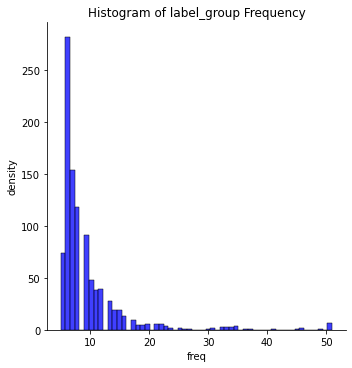

In [15]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 10))
sns.displot(a["freq"][:1000], color = 'blue')
plt.ylabel("density")
plt.title("Histogram of label_group Frequency")
plt.show()

In [16]:
# check summary of statistics
a.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.99])

label_group          freq
count  1.101400e+04  11014.000000
mean   2.138621e+09      3.109679
std    1.235108e+09      2.940827
min    2.580470e+05      2.000000
25%    1.054134e+09      2.000000
50%    2.141621e+09      2.000000
75%    3.192278e+09      3.000000
80%    3.421221e+09      4.000000
99%    4.251806e+09     14.000000
max    4.294197e+09     51.000000

In [17]:
# check character length per observations
train_csv ['length'] = train_csv['title'].apply(len)
train_csv

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group  length  
0        249114794      25  
1       2937985045      60  
2       2395904891      43  
3       4093212188      98  
4       3648931069      33  
...            ...     ...  
34245   3776555725      67  
34246   2736479533      47  
34247   4101248785      63  
34248   1663538013      88  
34249    459464107      52  

[34250 rows x 6 columns]

In [18]:
# check summary of statistics
train_csv.length.describe()

count    34250.000000
mean        56.163474
std         25.100492
min          5.000000
25%         36.000000
50%         53.000000
75%         73.000000
max        357.000000
Name: length, dtype: float64

In [19]:
# average length is around 56 characters

In [20]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# word cloud visualization
from wordcloud import WordCloud
from PIL import Image

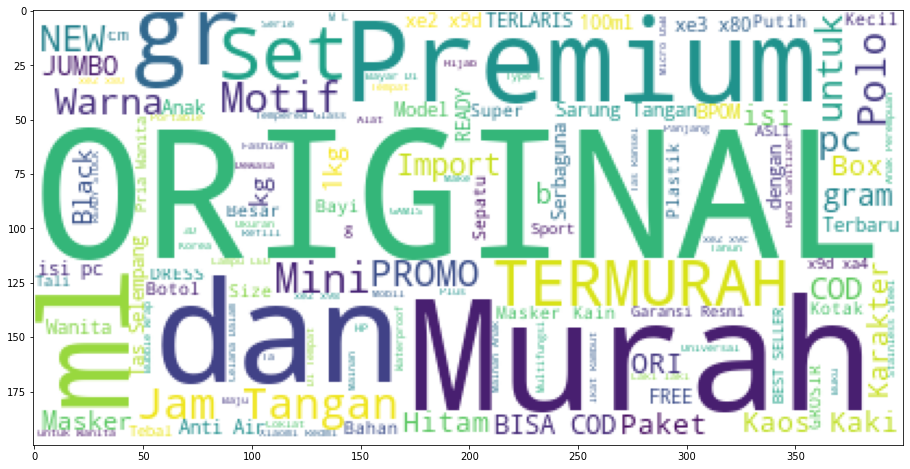

In [22]:
# plot
wc = WordCloud (
    background_color = 'white',
    max_words = 200,
    # random_state = seed,
    max_font_size = 100
)

wc.generate(' '.join(train_csv['title']))
plt.figure(figsize = (20,8))
plt.imshow(wc)
plt.show()

In [23]:
# top common words were: ORIGINAL, Murah, dan, Set, ml, Premium

## Preprocessing old

Define preprocessing function for later

In [113]:
import nltk
nltk.download('stopwords')
import re

# set stopwords per language
stopwords_eng = nltk.corpus.stopwords.words('english')
stopwords_ind = nltk.corpus.stopwords.words('indonesian')

# define function to remove stop words and common special characters
def remove_punctuations_stopwords(text):
    text = text.strip() # remove trailing and leading characters
    text = text.lower() # convert to lower cases
    
    # punctuations = r'[<>?/\,-!@%#$^&*|_+)(:;"{}=`~.]' # define punctuations and 0 as a string
    punctuations = r'[/\,\-!@%#$^&*|_+)(:]'
    text = re.sub(punctuations, '', text) # put each string in ''

    #common_words = r["hari keren kere kw super baik jual jualan quality best free  kwalitas berkualitas kualitas bagus terbaik kembali dijamin beli gratis murah free diskon ongkir cek berkualitas original asli kualitas uang jaminan jamin terjamin buatan buat kirim wilayah luar kota jawa bali jakarta surabaya bulan month year day tahun hari harian anda your nikmat singapore malaysia indonesia vietnam thailand filipina bangkok jepang buy one get dapat dua two satu meriah kirim send pengiriman paket hemat uang kembali dapat guarantee buatan lokal dalam internasional karya termurah paling murah terbaik cheap murah biaya]"
    #text = re.sub(common_words, '', text)

    # remove stop words
    string = ""
    for word in text.split():
        if not word in stopwords_eng: # remove stop words in english
          if not word in stopwords_ind: # remove stop words in indonesian
           string += word + " "


    return string.strip()


def remove_strange_words(list_text):
    strange_words = ['aaa', 'aaaa', 'aaaaa', 'abc', 'abcd', 'bb', 'bbb', 'bbbb', 'ccc', 'cccc', 'thn', 'th', 'bln']
    return [w for w in list_text if w not in strange_words]

def join_string(list_text):
  text = " ".join(list_text)
  return text


# replace word that concatenate with other word
def remove_concatenate_2_words(text):
    list_words = []
    for w in list_words:
        text = text.replace(w, '')
    return text


# remove big number and split text that contains word and number
def remove_big_number(list_text):
    words = []
    for w in list_text:
        sub_w = re.split('(\d+)',w)
        for item in sub_w:
            try:
                tmp = int(item)
                if tmp < 7000:
                    if (tmp>1000) and (tmp % 100 == 0): # for even number
                        words.append(str(tmp))
                    elif (tmp<=1000) and (tmp>100) and (tmp % 10 == 0 ):
                        words.append(str(tmp))
                    elif (tmp<=100) and (tmp % 2 == 0):
                        words.append(str(tmp))
            except:
                words.append(item)
    return words


def remove_zero_val(list_text):
    return [w for w in list_text if w not in ['0']]


def remove_common_words(list_text): # XXXXXX
    common_words = "hari keren kere kw super baik jual jualan quality best free  kwalitas berkualitas kualitas bagus terbaik kembali dijamin beli gratis murah free diskon ongkir cek berkualitas original asli kualitas uang jaminan jamin terjamin buatan buat kirim wilayah luar kota jawa bali jakarta surabaya bulan month year day tahun hari harian anda your nikmat singapore malaysia indonesia vietnam thailand filipina bangkok jepang buy one get dapat dua two satu meriah kirim send pengiriman paket hemat uang kembali dapat guarantee buatan lokal dalam internasional karya termurah paling murah terbaik cheap murah biaya".split(' ')
    return [w for w in list_text if w not in common_words]






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
# test
title = pd.DataFrame({"title": ["The quality qualitying product in the marketing!", "Buy now 0000 aaaa abc market1000", 
                               "Double Tape 10000 3M VHB 12 mm x 4,5", "m ORIGINAL / DOUBLE FOAM TAPE"],
                     "number": [1, 2, 3, 4]})

#title['title_new'] = title['title'].apply(lambda x : remove_punctuations_stopwords(x))
## title['title_new'] = title['title'].apply(lambda x : remove_concatenate_2_words(x))
# title['title_new'] = title['title'].apply(lambda x : remove_big_number(x))
# title['title_new'] = title_new['title'].apply(lambda x : remove_zero_val(x))
# title['title_new'] = title_new['title'].apply(lambda x : remove_common_words(x))
title['title_new'] = title['title'].apply(lambda x : remove_strange_words(x))
# title['title_new'] = title_new['title'].apply(lambda x: list(np.unique(x)))
title['title_new'] = title['title_new'].apply(lambda x: join_string(x))
title

title  number  \
0  The quality qualitying product in the marketing!       1   
1                  Buy now 0000 aaaa abc market1000       2   
2              Double Tape 10000 3M VHB 12 mm x 4,5       3   
3                     m ORIGINAL / DOUBLE FOAM TAPE       4   

                                           title_new  
0  T h e   q u a l i t y   q u a l i t y i n g   ...  
1  B u y   n o w   0 0 0 0   a a a a   a b c   m ...  
2  D o u b l e   T a p e   1 0 0 0 0   3 M   V H ...  
3  m   O R I G I N A L   /   D O U B L E   F O A ...

In [40]:
# test
title = ["The best quality product in the marketing! Buy now", "Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE"]
title_new = map(textpreprocessing, title)
print(list(title_new))

['best quality product marketing buy', 'double tape 3m vhb 12 mm x 45 original double foam tape']


In [ ]:
train_csv['title_clean'] = train_csv['title'].map(textpreprocessing) # create column without stop words and common special character
train_csv

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group  length                                        title_clean  \
0        249114794      25                          paper bag victoria secret   
1       2937985045      60  double tape 3m vhb 12 mm x 45 original double ...   
2       2395904891      43        maling tts canned pork luncheon meat 397 gr   
3       4093212188      98  daster batik lengan pendek motif acak campur l...   
4       3648931069      33                  nescafe \xc3\x89clair latte 220ml   
...            ...     ...                                                ...   
34245   3776555725      67  masker bahan kain spunbond non woven 75 gsm 3 ...   
34246   2736479533      47          mamypoko pants royal soft 70 popok celana   
34247   4101248785      63  khanzaacc robot re101s 1.2mm subwoofer bass me...   
34248   1663538013      88  kaldu non msg halal mama ayam kampung sapi lok...   
34249    459464107      52   flex tape pelapis bocor isolasi ajaib anti bocor   

       length_clean  
0                25  
1                55  
2                43  
3                89  
4                33  
...             ...  
34245            62  
34246            41  
34247            63  
34248            75  
34249            48  

[34250 rows x 8 columns]

In [ ]:
# check character length per observations for title_clean
train_csv ['length_clean'] = train_csv['title_clean'].apply(len)
train_csv

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group  length                                        title_clean  \
0        249114794      25                          paper bag victoria secret   
1       2937985045      60  double tape 3m vhb 12 mm x 45 original double ...   
2       2395904891      43        maling tts canned pork luncheon meat 397 gr   
3       4093212188      98  daster batik lengan pendek motif acak campur l...   
4       3648931069      33                  nescafe \xc3\x89clair latte 220ml   
...            ...     ...                                                ...   
34245   3776555725      67  masker bahan kain spunbond non woven 75 gsm 3 ...   
34246   2736479533      47          mamypoko pants royal soft 70 popok celana   
34247   4101248785      63  khanzaacc robot re101s 1.2mm subwoofer bass me...   
34248   1663538013      88  kaldu non msg halal mama ayam kampung sapi lok...   
34249    459464107      52   flex tape pelapis bocor isolasi ajaib anti bocor   

       length_clean  
0                25  
1                55  
2                43  
3                89  
4                33  
...             ...  
34245            62  
34246            41  
34247            63  
34248            75  
34249            48  

[34250 rows x 8 columns]

## Preprocessing

In [5]:
# Import stopwords and reference corpus
import nltk
nltk.download('stopwords')

import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
# set stopwords per language
stopwords_eng = nltk.corpus.stopwords.words('english')
stopwords_ind = nltk.corpus.stopwords.words('indonesian')

# for punctuation
import string
punctuations_eng = string.punctuation
punctuations_list = punctuations_eng

# stemming
from nltk.stem.porter import PorterStemmer
st = PorterStemmer()

# # lemamatizer
# from nltk.stem import WordNetLemmatizer # to give you the root word
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# wnl = WordNetLemmatizer()

In [124]:
# define function to remove stop words and common special characters
def textpreprocessing(text):
    text = text.strip() # remove trailing and leading characters
    text = text.lower() # convert to lower cases

    # remove punctionations
    translator = str.maketrans('', '', punctuations_list)
    text = text.translate(translator)

    string=""
    for word in text.split():
        if not word in stopwords_eng: # remove stop words in english
          if not word in stopwords_ind: # remove stop words in indonesian
           string += word + " "

    return string.strip()

In [212]:
train_csv['title_clean'] = train_csv['title'].apply(lambda x: [st.stem(y) for y in x]) # Stem every word.
#train_csv['title_clean'] = train_csv['title_clean'].str.join(",")
train_csv.head(5)

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  \
0                          Paper Bag Victoria Secret    249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069   

                                         title_clean  length_clean  
0  [p, a, p, e, r,  , b, a, g,  , v, i, c, t, o, ...            25  
1  [d, o, u, b, l, e,  , t, a, p, e,  , 3, m,  , ...            55  
2  [m, a, l, i, n, g,  , t, t, s,  , c, a, n, n, ...            43  
3  [d, a, s, t, e, r,  , b, a, t, i, k,  , l, e, ...            89  
4  [n, e, s, c, a, f, e,  , \, x, c, 3, \, x, 8, ...            33

In [214]:
#train_csv['title_clean'] = train_csv['title_clean'].apply(lambda x: x.str.replace(',',''))
#train_csv['title_clean'] = train_csv['title_clean'].replace(',','', regex=True, inplace=True)
#train_csv.title_clean = train_csv.title_clean.apply(lambda x : x.replace(',',''))
train_csv['title_clean'] = train_csv['title_clean'].apply(str.replace(",",""))
train_csv.head()

TypeError: ignored

In [201]:
train_csv['title_clean'] = train_csv['title'].map(textpreprocessing) # create column without stop words and common special character
train_csv.head()

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group                                        title_clean  \
0        249114794                          paper bag victoria secret   
1       2937985045  double tape 3m vhb 12 mm x 45 original double ...   
2       2395904891        maling tts canned pork luncheon meat 397 gr   
3       4093212188  daster batik lengan pendek motif acak campur l...   
4       3648931069                    nescafe xc3x89clair latte 220ml   
...            ...                                                ...   
34245   3776555725  masker bahan kain spunbond non woven 75 gsm 3 ...   
34246   2736479533          mamypoko pants royal soft 70 popok celana   
34247   4101248785  khanzaacc robot re101s 12mm subwoofer bass met...   
34248   1663538013  kaldu non msg halal mama ayam kampung sapi lok...   
34249    459464107   flex tape pelapis bocor isolasi ajaib anti bocor   

       length_clean  
0                25  
1                55  
2                43  
3                89  
4                33  
...             ...  
34245            62  
34246            41  
34247            63  
34248            75  
34249            48  

[34250 rows x 7 columns]

In [9]:
train_csv['title_clean'].unique() # checking

array(['paper bag victoria secret',
       'double tape 3m vhb 12 mm x 45 original double foam tape',
       'maling tts canned pork luncheon meat 397 gr', ...,
       'khanzaacc robot re101s 1.2mm subwoofer bass metal wired headset',
       'kaldu non msg halal mama ayam kampung sapi lokal jamur bkn alsultan biocell',
       'flex tape pelapis bocor isolasi ajaib anti bocor'], dtype=object)

In [10]:
print("Number of unique title_clean:", train_csv['title_clean'].nunique())
print("Number of unique label_group:",train_csv['label_group'].nunique())

Number of unique title_clean: 32423
Number of unique label_group: 11014


In [11]:
# check character length per observations for title_clean
train_csv ['length_clean'] = train_csv['title_clean'].apply(len)
train_csv

posting_id                                 image  \
0       train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg   
1      train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg   
2      train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg   
3      train_2406599165  00117e4fc239b1b641ff08340b429633.jpg   
4      train_3369186413  00136d1cf4edede0203f32f05f660588.jpg   
...                 ...                                   ...   
34245  train_4028265689  fff1c07ceefc2c970a7964cfb81981c5.jpg   
34246   train_769054909  fff401691371bdcb382a0d9075dfea6a.jpg   
34247   train_614977732  fff421b78fa7284284724baf249f522e.jpg   
34248  train_3630949769  fff51b87916dbfb6d0f8faa01bee67b8.jpg   
34249  train_1792180725  ffffa0ab2ae542357671e96254fa7167.jpg   

            image_phash                                              title  \
0      94974f937d4c2433                          Paper Bag Victoria Secret   
1      af3f9460c2838f0f  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   
2      b94cb00ed3e50f78        Maling TTS Canned Pork Luncheon Meat 397 gr   
3      8514fc58eafea283  Daster Batik Lengan pendek - Motif Acak / Camp...   
4      a6f319f924ad708c                  Nescafe \xc3\x89clair Latte 220ml   
...                 ...                                                ...   
34245  e3cd72389f248f21  Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...   
34246  be86851f72e2853c    MamyPoko Pants Royal Soft - S 70 - Popok Celana   
34247  ad27f0d08c0fcbf0  KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...   
34248  e3b13bd1d896c05c  Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...   
34249  af8bc4b2d2cf9083  FLEX TAPE PELAPIS BOCOR / ISOLASI AJAIB / ANTI...   

       label_group                                        title_clean  \
0        249114794                          paper bag victoria secret   
1       2937985045  double tape 3m vhb 12 mm x 45 original double ...   
2       2395904891        maling tts canned pork luncheon meat 397 gr   
3       4093212188  daster batik lengan pendek motif acak campur l...   
4       3648931069                  nescafe \xc3\x89clair latte 220ml   
...            ...                                                ...   
34245   3776555725  masker bahan kain spunbond non woven 75 gsm 3 ...   
34246   2736479533          mamypoko pants royal soft 70 popok celana   
34247   4101248785  khanzaacc robot re101s 1.2mm subwoofer bass me...   
34248   1663538013  kaldu non msg halal mama ayam kampung sapi lok...   
34249    459464107   flex tape pelapis bocor isolasi ajaib anti bocor   

       length_clean  
0                25  
1                55  
2                43  
3                89  
4                33  
...             ...  
34245            62  
34246            41  
34247            63  
34248            75  
34249            48  

[34250 rows x 7 columns]

In [12]:
# check summary of statistics
train_csv.length_clean.describe()

count    34250.000000
mean        52.716263
std         23.579816
min          0.000000
25%         35.000000
50%         49.000000
75%         68.000000
max        356.000000
Name: length_clean, dtype: float64

In [ ]:
# mean length reduced from 56 to 52

### Word Cloud

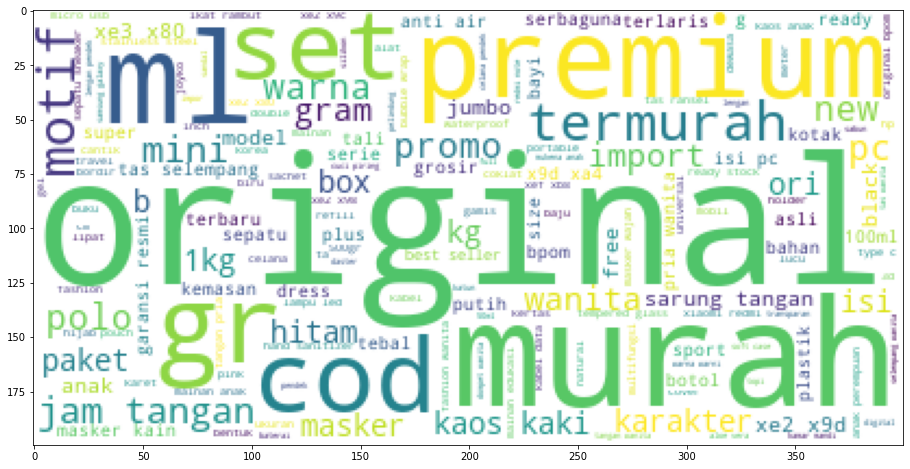

In [ ]:
# plot word cloud
wc_clean = WordCloud (
    background_color = 'white',
    max_words = 200,
    # random_state = seed,
    max_font_size = 100
)

wc_clean.generate(' '.join(train_csv['title_clean']))
plt.figure(figsize = (20,8))
plt.imshow(wc_clean)
plt.show()

In [ ]:
# top common words were: original, murah, ml, premium, cod

# indonesian stopword dan was removed as common word

In [ ]:
import collections
from collections import Counter

In [ ]:
# define function to plot most common words 
def wordBarGraphFunction(df,column,title):
    # sw_ind = nltk.corpus.stopwords.words('indonesian')
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    # popular_words_nonstop = [w for w in popular_words if w not in sw_ind]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words[0:50]))
    plt.title(title)
    plt.show()

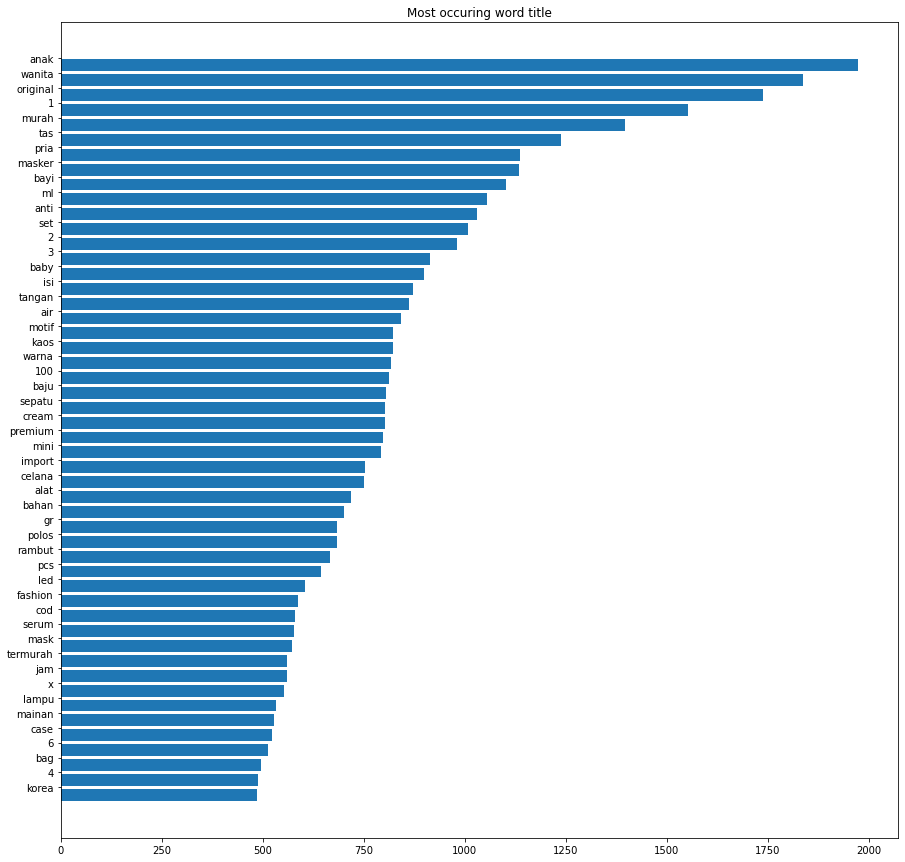

In [ ]:
plt.figure(figsize = (15,15))
wordBarGraphFunction(train_csv,'title_clean', "Most occuring word title")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


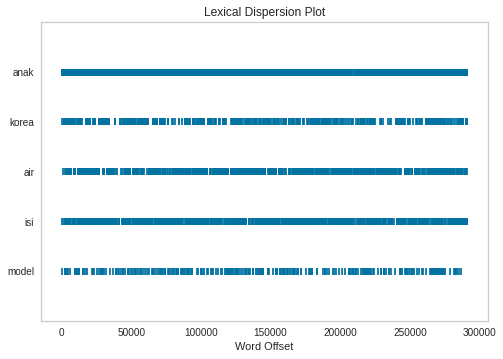

In [ ]:
from yellowbrick.text import DispersionPlot

# Create a list of words from the corpus text
text = [doc.split() for doc in train_csv['title_clean']]

# Choose words whose occurence in the text will be plotted
target_words = ['anak', 'korea', 'air', 'isi', 'model'] # random words

# Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words)
visualizer.fit(text)
visualizer.show()

In [ ]:
print(text)

[['paper', 'bag', 'victoria', 'secret'], ['double', 'tape', '3m', 'vhb', '12', 'mm', 'x', '45', 'original', 'double', 'foam', 'tape'], ['maling', 'tts', 'canned', 'pork', 'luncheon', 'meat', '397', 'gr'], ['daster', 'batik', 'lengan', 'pendek', 'motif', 'acak', 'campur', 'leher', 'kancing', 'dpt00100', 'batik', 'karakter', 'alhadi'], ['nescafe', '\\xc3\\x89clair', 'latte', '220ml'], ['celana', 'wanita', 'bb', '4584', 'kgharem', 'wanita', 'cod'], ['jubah', 'anak', 'size', '112', 'thn'], ['kulot', 'plisket', 'salur', 'candy', 'plisket', 'wish', 'kulot', 'premium', 'kulot', 'pelangi', 'premiumhieka', 'kulot'], ['[logu]', 'tempelan', 'kulkas', 'magnet', 'angka', 'tempelan', 'angka', 'magnet'], ['big', 'sale', 'sepatu', 'pantofel', 'kulit', 'keren', 'kerja', 'kantor', 'laki', 'pria', 'cowok', 'dinas', 'resmi', 'formal', 'pesta', 'kickers'], ['atasan', 'rajut', 'wanita', 'lisdia', 'sweater'], ['pashmina', 'kusut', 'rawis', 'polos', 'crinkle', 'shawl', 'murah', 'banget'], ['pashmina', 'kusut'

### Interactive Word Distance Map

In [ ]:
# create dictionary of tokens
dictionary = corpora.Dictionary(text) # text contains list of arrays of words
print(dictionary)

Dictionary(29549 unique tokens: ['bag', 'paper', 'secret', 'victoria', '12']...)


In [ ]:
bow_text = [dictionary.doc2bow(txt) for txt in text] # bag of words
print(bow_text)

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1)], [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)], [(22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)], [(34, 1), (35, 1), (36, 1), (37, 1)], [(38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2)], [(44, 1), (45, 1), (46, 1), (47, 1), (48, 1)], [(49, 1), (50, 4), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1)], [(57, 1), (58, 2), (59, 1), (60, 2), (61, 2)], [(62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)], [(43, 1), (78, 1), (79, 1), (80, 1), (81, 1)], [(82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1)], [(82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1)], [(92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (

In [ ]:
! pip install pyLDAvis

import pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=268a581e935af12ee68b60e8c69ae9b614da7c28ad52cc7440114652f2288863
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
from gensim import models
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# create tfidf model
tfidf_model = models.TfidfModel(bow_text)
tfidf_text = tfidf_model[bow_text]

# LDA model
lda = models.LdaMulticore(tfidf_text, num_topics = 20, id2word = dictionary, passes = 2, workers = 2)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
pyLDAvis.enable_notebook()
visual = gensimvis.prepare(lda, tfidf_text, dictionary)
visual

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.171854  0.005335       1        1  6.411831
1      0.129453  0.004808       2        1  5.711954
13    -0.096612  0.140686       3        1  5.382496
8      0.058560  0.007548       4        1  5.318661
0     -0.065248  0.093052       5        1  5.311657
12     0.055532 -0.008758       6        1  5.255662
16    -0.040120  0.006343       7        1  5.114923
9      0.017310 -0.102996       8        1  5.085198
6      0.039121  0.070563       9        1  5.074470
19    -0.007799 -0.088878      10        1  4.973658
15    -0.077462 -0.075096      11        1  4.941542
17    -0.114811 -0.075109      12        1  4.917745
18     0.032205  0.080664      13        1  4.878771
2     -0.002763 -0.070050      14        1  4.814800
3     -0.022576 -0.042081      15        1  4.790569
7     -0.067090  0.037510      16        1  4.738950
4      0.005241  0.016007      17        1  4.722835
5     -0.026331 -0.002708      18        1  4.202067
11     0.041256  0.014450      19        1  4.192400
10    -0.029719 -0.011290      20        1  4.159813, topic_info=           Term        Freq       Total Category  logprob  loglift
500         tas  182.000000  182.000000  Default  30.0000  30.0000
1437        rak   81.000000   81.000000  Default  29.0000  29.0000
497   selempang   63.000000   63.000000  Default  28.0000  28.0000
1748     jilbab   71.000000   71.000000  Default  27.0000  27.0000
672       dress   87.000000   87.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2681   wireless    9.396222   39.302354  Topic20  -5.9879   1.7487
77       sepatu    9.824331  124.094293  Topic20  -5.9433   0.6435
1657     lembar    8.087154   19.917260  Topic20  -6.1379   2.2784
10     original    8.254848  200.010252  Topic20  -6.1174  -0.0079
300        anti    8.194315  139.368828  Topic20  -6.1247   0.3460

[1370 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
7092       7  0.800873       .
7092      20  0.114410       .
238        1  0.032325       1
238        2  0.070039       1
238        3  0.043101       1
...      ...       ...     ...
1408      11  0.857808  zaitun
16951      3  0.805482   zeera
13148     10  0.930301  zernii
6524       9  0.763749    zoya
6524      12  0.127292    zoya

[4820 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 14, 9, 1, 13, 17, 10, 7, 20, 16, 18, 19, 3, 4, 8, 5, 6, 12, 11])

In [ ]:
len(tfidf_text)

34250

### TF-IDF Vector dataframe

In [126]:
documents = train_csv["title_clean"].tolist() # test
documents

['paper bag victoria secret',
 'double tape 3m vhb 12 mm x 45 original double foam tape',
 'maling tts canned pork luncheon meat 397 gr',
 'daster batik lengan pendek motif acak campur leher kancing dpt00100 batik karakter alhadi',
 'nescafe xc3x89clair latte 220ml',
 'celana wanita bb 4584 kgharem wanita cod',
 'jubah anak size 112 thn',
 'kulot plisket salur candy plisket wish kulot premium kulot pelangi premiumhieka kulot',
 'logu tempelan kulkas magnet angka tempelan angka magnet',
 'big sale sepatu pantofel kulit keren kerja kantor laki pria cowok dinas resmi formal pesta kickers',
 'atasan rajut wanita lisdia sweater',
 'pashmina kusut rawis polos crinkle shawl murah banget',
 'pashmina kusut rawis polos crinkle shawl murah banget part 2',
 'lampu led t5 speedometer dashboard motor mobil 5050 speedo bright',
 'charger vizz vztc11 batok charger vizz 1a original real kapasitas',
 'korek kuping led balita cherrybabykidsshop sp lc',
 'marks spencer rose hand body lotion 250 ml',
 'sa

In [190]:
# test
words = ['is', 'are', 'bought', 'buys', 'giving', 'jumps', 'jumped', 'birds', 'do', 'does', 'did', 'doing', 'Doing','moisturizing']
for word in words:
    print(word, st.stem(word))

is is
are are
bought bought
buys buy
giving give
jumps jump
jumped jump
birds bird
do do
does doe
did did
doing do
Doing do
moisturizing moistur


In [157]:
stem_doc = []
for word in words:
  stem_doc.append(st.stem(word))
#stem_doc = ' '.join(stem_doc)
stem_doc

['is',
 'are',
 'bought',
 'buy',
 'give',
 'jump',
 'jump',
 'bird',
 'do',
 'doe',
 'did',
 'do',
 'moistur']

In [185]:
words = ['dazzling white pemutih gigi teeth whitening essence serum a544 putih']

In [186]:
from itertools import chain
result = list(chain.from_iterable(map(str.split, words)))
result

['dazzling',
 'white',
 'pemutih',
 'gigi',
 'teeth',
 'whitening',
 'essence',
 'serum',
 'a544',
 'putih']

In [189]:
stem_doc = []
for word in words:
  stem_doc.append(st.stem(word))
stem_doc = ' '.join(stem_doc)
stem_doc

'is are bought buy give jump jump bird do doe did do moistur'

In [166]:
from itertools import chain

for desc in documents:
  stem_doc = []
  for word in desc.split(" "):
    stem_doc.append(st.stem(word))
    if stem_doc = ' '.join(stem_doc)

stem_doc

SyntaxError: ignored

In [128]:
stem_doc

['paper bag victoria secret',
 'double tape 3m vhb 12 mm x 45 original double foam tap',
 'maling tts canned pork luncheon meat 397 gr',
 'daster batik lengan pendek motif acak campur leher kancing dpt00100 batik karakter alhadi',
 'nescafe xc3x89clair latte 220ml',
 'celana wanita bb 4584 kgharem wanita cod',
 'jubah anak size 112 thn',
 'kulot plisket salur candy plisket wish kulot premium kulot pelangi premiumhieka kulot',
 'logu tempelan kulkas magnet angka tempelan angka magnet',
 'big sale sepatu pantofel kulit keren kerja kantor laki pria cowok dinas resmi formal pesta kick',
 'atasan rajut wanita lisdia sweat',
 'pashmina kusut rawis polos crinkle shawl murah banget',
 'pashmina kusut rawis polos crinkle shawl murah banget part 2',
 'lampu led t5 speedometer dashboard motor mobil 5050 speedo bright',
 'charger vizz vztc11 batok charger vizz 1a original real kapasita',
 'korek kuping led balita cherrybabykidsshop sp lc',
 'marks spencer rose hand body lotion 250 ml',
 'saffron 0

In [75]:
import gensim
from gensim import corpora, models

# create dictionary of tokens
# documents = train_csv["title_clean"].tolist() # convert column to list
documents = [doc.split() for doc in train_csv['title_clean']] # Create a list of words from the corpus text
dictionary = corpora.Dictionary(documents) # text contains list of arrays of words

bow_text = [dictionary.doc2bow(txt) for txt in documents] # bag of words
print(bow_text)

Output hidden; open in https://colab.research.google.com to view.

In [76]:
# create tfidf model
tfidf_model = models.TfidfModel(bow_text)
tfidf_text = tfidf_model[bow_text]

#TF-IDF VEctorization
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidf_vect = TfidfVectorizer(min_df=10, max_df=0.8) # ignore frequency lower than 10 and max frequency of 80%
X_tfidf = tfidf_vect.fit_transform(train_csv["title"])
x_features = pd.DataFrame(X_tfidf.toarray())
x_features

0     1     2     3     4     5     6     7     8     9     ...  \
0      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3      0.314191   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
34245  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
34246  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
34247  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
34248  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
34249  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

       4245  4246  4247  4248  4249  4250  4251  4252  4253  4254  
0       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
34245   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
34246   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
34247   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
34248   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
34249   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[34250 rows x 4255 columns]

In [77]:
from sys import getsizeof
getsizeof(x_features)

1165870160

## Similarity Classification

In [42]:
from sklearn.model_selection import train_test_split

# splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(x_features, 
                                                    train_csv['label_group'], 
                                                    test_size=0.20, 
                                                    random_state=seed)


In [ ]:
# reduce dimensions to 95%
#from sklearn.decomposition import PCA
#pca = PCA(0.95)
# pca.fit(X_train)